In [1]:
import numpy as np
import colocationship as cl
import copy
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_hdf('/scratch/share/datasets/a21/a21_checkins_30k_users.h5', key='table')

In [3]:
df_network = pd.read_hdf('/scratch/share/datasets/a21/a21_checkins_with_network.h5', key='table')

In [4]:
egolist = list(set(df_network['user_id'].tolist()))
alterlist = list(set(df_network['tgt'].tolist()))

In [5]:
df_part = df_network[df_network['tgt'].isin(egolist)]

# What is Friendship Network (reciprocal friendships)

In [7]:
df_A = df_part.copy()
df_B = df_part.copy()
df_A = df_A.rename(columns={"user_id": "userid_x", "tgt": "userid_y"})
df_B = df_B.rename(columns={"user_id": "userid_y", "tgt": "userid_x"})
df_inner = pd.merge(df_A, df_B, on =['userid_x', 'userid_y'])
df_reciprocal = df_inner.groupby(by=['userid_x', 'userid_y']).size().reset_index(name='N_contact')

More than 30 reciprocal contact

In [8]:
df_reciprocal_valid  = df_reciprocal[df_reciprocal['N_contact']>=30]

In [10]:
df_friend  = df_reciprocal_valid[['userid_x', 'userid_y']]

In [11]:
df_AB = pd.concat([df_A, df_B])[['userid_x', 'userid_y']]
df_call_info = df_AB.groupby(['userid_x', 'userid_y']).size().reset_index(name='N_call')

# DF checkins

In [12]:
df_checkin = df_part[['user_id', 'lat', 'lon', 'location_id', 'created_at']].copy()
df_checkin.columns = ['userid', 'lat', 'lon', 'placeid', 'datetime']

# Let's Focus on Main Results

In [13]:
co_locationship = cl.Co_Locationship(df_checkin, mins_records=150, missing='-')

In [15]:
# First time, should run co_locationship
placeidT = co_locationship()

In [16]:
# Run in the first time (it takes 30 mins)
# co_locationship.build_network(freq='H')
# cln.to_csv('BZR_raw_meetup_150.csv', index=False)

cln = pd.read_csv('interim-150/BZR_raw_meetup_150.csv')
co_locationship.network = cln

In [19]:
# # Run in the first time (it takes 6 hours)
# cln_details = co_locationship.calculate_info()
# cln_details.to_csv('BZR_CLN_CE_info_150.csv', index=False)

cln_details= pd.read_csv('interim-150/BZR_CLN_CE_info_150.csv')
co_locationship.network_details = cln_details

In [21]:
cln_filtered = co_locationship.network_control(quality=True, 
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150)

In [22]:
print(cln_filtered['userid_x'].nunique(), cln_filtered['userid_y'].nunique())

3608 4346


In [23]:
# # Run in the first time (it takes 1 hour)
# co_locationship.calculate_network(verbose=False, filesave=True, name='BZR')

# The second time, you can just read the saved result
co_locationship.network_details = pd.read_csv('interim-150/BZR_CLN_network_details_H.csv')
co_locationship.final_userlist = sorted(list(set(co_locationship.network_details['userid_x'].tolist())))

In [24]:
cl.util.save_object(co_locationship, 'BZR_150_colocationship.pickle')

# Social-Relationship Network Experiment

In [25]:
social_relationship = cl.Social_Relationship(df_checkin,df_friend, 
                                             mins_records=150, 
                                             missing='-')

In [27]:
# given the same time unit, we can just the placeid sequence generated by co-locationship
# otherwise, also run `social_relationship()` to generate placeid sequence again.
social_relationship.placeidT = placeidT

In [28]:
# # Run in the first time (it takes 16 mins)
# srn_details = social_relationship.calculate_info()
# srn_details.to_csv('BZR_SRN_CE_info_reciprocal_30.csv', index=False)

# # The second time, you can just read the saved result
social_relationship.network_details = pd.read_csv('reciprocal30_150/BZR_SRN_CE_info_reciprocal_30.csv')

In [29]:
srn_filtered = social_relationship.network_control(
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150,
                                freq='H')

In [33]:
# # Run in the first time (it takes 28 hour)
# social_relationship.calculate_network(verbose=False, filesave=True, name='BZR_reciprocal_30')

# The second time, you can just read the saved result
social_relationship.network_details = pd.read_csv('reciprocal30_150/BZR_reciprocal_30_SRN_network_details_H.csv')
social_relationship.final_userlist = sorted(list(set(social_relationship.network_details['userid_x'].tolist())))

In [34]:
cl.util.save_object(co_locationship, 'BZR_150_reciprocal_30_SRN.pickle')

# No_call_history_colocation network

In [35]:
call_pair = []
for a,b in zip(df_call_info.userid_x, df_call_info.userid_y): 
     call_pair.append((a, b))

In [36]:
non_call_co_locationship = copy.deepcopy(co_locationship)

In [37]:
exclude_call_network = cln_filtered[~cln_filtered[['userid_x', 
                                                   'userid_y']].apply(tuple, axis=1).isin(call_pair)]
non_call_co_locationship.network_details = exclude_call_network

In [38]:
non_call_cln_filtered = non_call_co_locationship.network_control(quality=True, 
                                                                    contribution=True, 
                                                                    num_alters=10, 
                                                                    by=['userid_x', 'meetup', 'N_previous'], 
                                                                    ascending=[True, False, True],
                                                                    N_previous=150)

In [40]:
# # Run in the first time (it takes XXX hour)
# non_call_co_locationship.calculate_network(verbose=False, filesave=True, name='no_call')

non_call_co_locationship.network_details = pd.read_csv('no_call_150/no_call_CLN_network_details_H.csv')
non_call_co_locationship.final_userlist = sorted(list(set(non_call_co_locationship.network_details['userid_x'].tolist())))

In [41]:
cl.util.save_object(non_call_co_locationship, 'BZR_150_no_call_30_CLN.pickle')

# Import BZE network time windows

In [42]:
# total_network = network_sliding_windows(co_locationship.network, interval=1800, max_size=24)
total_network = pd.read_csv('interim-150/BZR_network_time_windows.csv')

# Building no_call SW1-Netowrk and Compute the details

In [45]:
def fast_SW_run(i):
    no_call_SW1_CLN = copy.deepcopy(co_locationship)
    SW_H1_Network = total_network[total_network['time-pos'].
                                  isin([-i,i])].groupby(['userid_x',
                                                             'userid_y'])['meetup'].sum().reset_index(name='meetup')
    SW1_exclude_call_network = SW_H1_Network[~SW_H1_Network[['userid_x', 
                                                   'userid_y']].apply(tuple, axis=1).isin(call_pair)]
    no_call_SW1_CLN.network = SW1_exclude_call_network
    no_call_SW1_CLN.calculate_info()
    
    no_call_SW1_cln_filtered = no_call_SW1_CLN.network_control(quality=True, 
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150)
    name = 'no_call_SW' + str(i)
    no_call_SW1_CLN.calculate_network(verbose=False, filesave=True, name=name)
    
    return no_call_SW1_CLN.network_details

In [46]:
SW_details = []

In [ ]:
for i in range(2, 25):
    print(i)
    network_details = fast_SW_run(i)
    network_details['interval'] = i
    SW_details.append(network_details)

2
3
4


In [264]:
# it takes 6 hours
no_call_SW1_cln_details = no_call_SW1_CLN.calculate_info()
no_call_SW1_cln_details.to_csv('BZR_no_call_SW1_CLN_CE_info_150.csv', index=False)

# # The second time, you can just read the saved result
# no_call_SW1_CLN.network_details = pd.read_csv('BZR_no_call_SW1_CLN_CE_info_150.csv')

In [265]:
print(no_call_SW1_CLN.network_details['userid_x'].nunique(), 
      no_call_SW1_CLN.network_details['userid_y'].nunique())

4415 4415


In [266]:
no_call_SW1_cln_filtered = no_call_SW1_CLN.network_control(quality=True, 
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150)

In [267]:
print(no_call_SW1_cln_filtered['userid_x'].nunique(), no_call_SW1_cln_filtered['userid_y'].nunique())

3477 4326


In [268]:
# Run in the first time (it takes 3 hour)
 no_call_SW1_CLN.calculate_network(verbose=False, filesave=True, name='SW1')

# # The second time, you can just read the saved result
# no_call_SW1_CLN.network_details = pd.read_csv('no_call_SW1_CLN_network_details_H.csv')
# no_call_SW1_CLN.final_userlist = sorted(list(set(no_call_SW1_CLN.network_details['userid_x'].tolist())))

,userid_x,userid_y,meetup,N_previous,n_prev_match,CE_alter,Pi_alter,Rank,CCE_alters,Pi_alters,CCE_ego_alter,Pi_ego_alter,CCE_ego_alters,Pi_ego_alters,LZ_entropy,Pi,ODLR,CODLR
131,0002D18309AF4230C09139D2FBB59E72,A4293E240B1874B41DB052DD0DD068A6,34,339,184,4.085345,0.301609,1,4.085345,0.301609,2.030021,0.738163,2.030021,0.738163,1.945826,0.751893,0.32,0.32
58,0002D18309AF4230C09139D2FBB59E72,4E26219CBFFE91D73B2AED3AE62E3410,32,521,361,2.923875,0.576680,2,2.770660,0.606604,2.089216,0.728368,2.073364,0.731003,1.945826,0.751893,0.40,0.40
9,0002D18309AF4230C09139D2FBB59E72,0A5900898073025A1F432EF4653AFCEB,29,201,436,2.173451,0.714228,3,2.190657,0.711310,1.821687,0.771715,1.922036,0.755730,1.945826,0.751893,0.32,0.48
106,0002D18309AF4230C09139D2FBB59E72,87E1A9F80264D1EA43DC9794714BC96C,29,503,225,3.927784,0.346334,4,2.192841,0.710939,2.139099,0.720024,1.940266,0.752791,1.945826,0.751893,0.44,0.64
78,0002D18309AF4230C09139D2FBB59E72,659BE695FD0B3BEAD95ABEF949E492BA,26,774,380,3.010154,0.559355,5,2.202267,0.709335,2.213912,0.707350,1.979860,0.746371,1.945826,0.751893,0.28,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032997,FFDDC356739ABE744793623DC6F4D06C,70AED96E6FF4A440EC2688510EC37BE6,2,240,513,2.484117,0.659926,15,1.345758,0.843166,1.358627,0.841328,1.224330,0.860250,1.386503,0.837329,0.64,0.72
1033037,FFDDC356739ABE744793623DC6F4D06C,DF847C0F82A4370F23557517A02810AE,2,267,204,4.314951,0.227698,16,1.342611,0.843615,1.395426,0.836043,1.221967,0.860578,1.386503,0.837329,0.24,0.72
1033046,FFDDC356739ABE744793623DC6F4D06C,F0E45B65559D134CE8177E9F57EBD25C,2,366,216,4.437227,0.181049,17,1.344784,0.843305,1.430519,0.830964,1.224058,0.860288,1.386503,0.837329,0.20,0.72
1033027,FFDDC356739ABE744793623DC6F4D06C,BFC430AFB977144B1515E5ACAA925A6F,2,368,265,4.006074,0.324578,18,1.346887,0.843005,1.434659,0.830362,1.226092,0.860006,1.386503,0.837329,0.08,0.72


# No-call 1H colocationship vs No-call SW-1H colocationship

In [269]:
compare_v6 = cl.ComparisonNetwork([no_call_SW1_CLN, non_call_co_locationship], 
                                  ['SW-1H-CN', 'CB-1H-CN']) 

In [270]:
compare_v6()

There are 3336 common users.


/home/zchen/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zchen/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/zchen/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/zchen/.local/lib/python3.6/site-packages/matplotlib/axes/_base.p

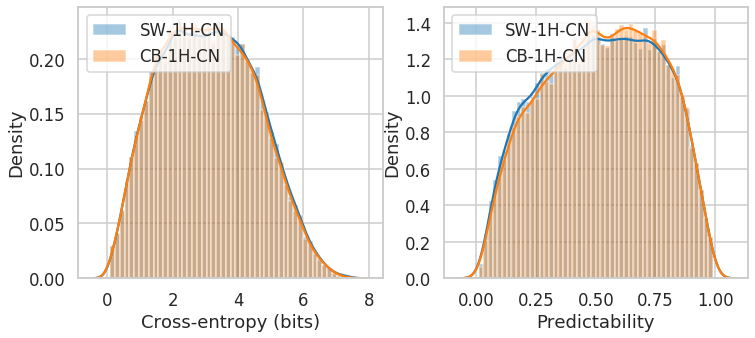

In [271]:
CE_v6 = compare_v6.plot_histogram(l=12,w=5)

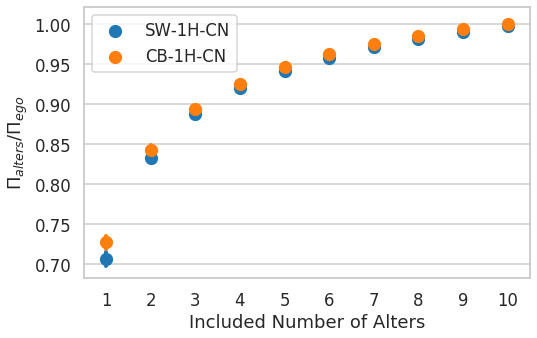

In [272]:
RCCP_alters_errorbar_v6 = compare_v6.plot_errorbar(target="RCCP alters", l=8,w=5)

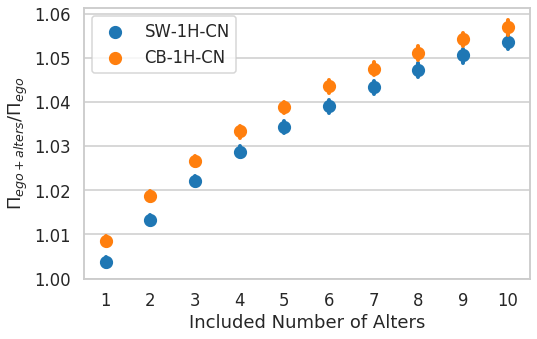

In [273]:
RCCP_ego_alters_errorbar_v6 = compare_v6.plot_errorbar(target='RCCP ego+alters', l=8,w=5)

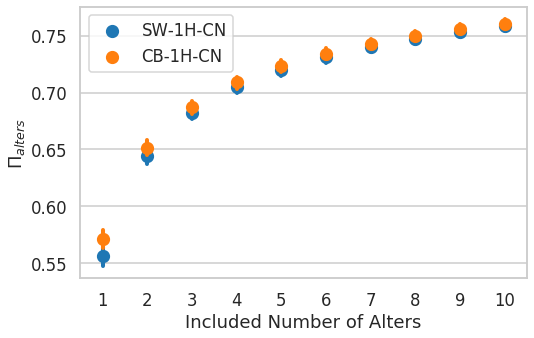

In [274]:
CCP_alters_errorbar_v6 = compare_v6.plot_errorbar(target='CCP alters', l=8,w=5)

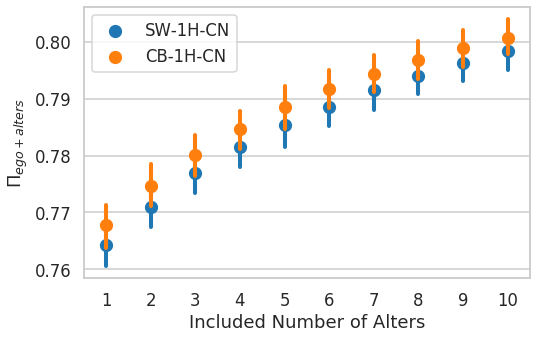

In [275]:
CCP_ego_alters_errorbar_v6 = compare_v6.plot_errorbar(target='CCP ego+alters', l=8,w=5)

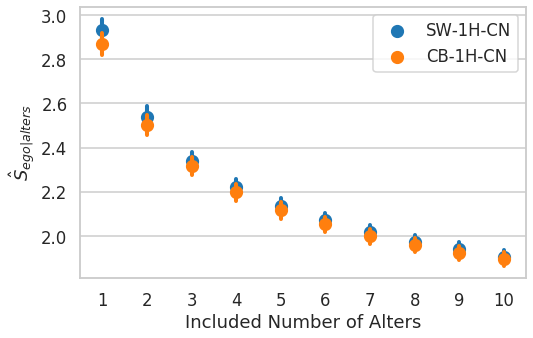

In [276]:
CCE_alters_errorbar_v6 = compare_v6.plot_errorbar(target='CCE alters', l=8,w=5)

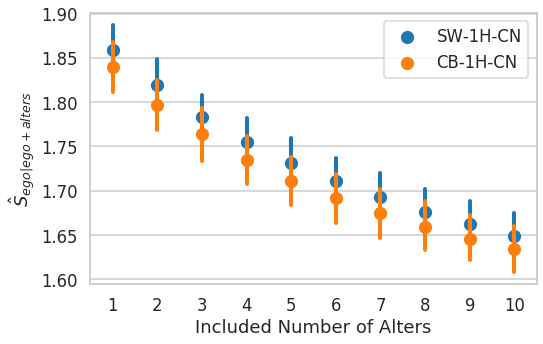

In [277]:
CCE_ego_alters_errorbar_v6 = compare_v6.plot_errorbar(target='CCE ego+alters', l=8,w=5)

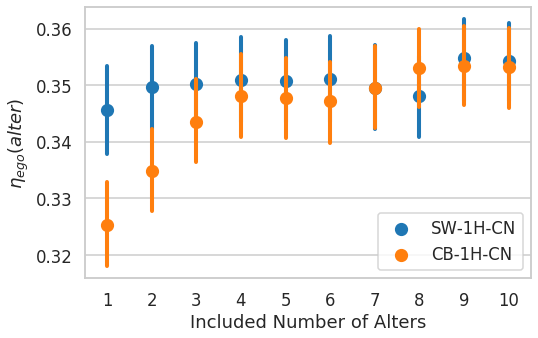

In [278]:
ODLR_errorbar_v6 = compare_v6.plot_errorbar(target='ODLR', l=8,w=5)

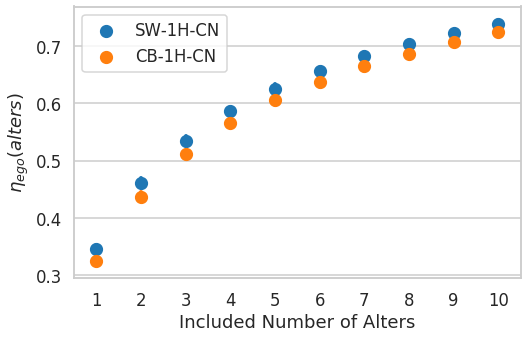

In [279]:
CODLR_errorbar_v6 = compare_v6.plot_errorbar(target='CODLR', l=8,w=5)

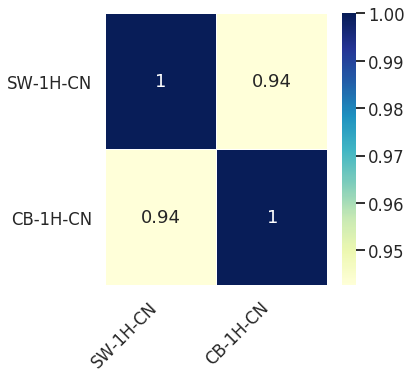

In [280]:
local_sim_v6 = compare_v6.plot_similarity(local=False, l=5,w=5)

In [281]:
compare_v6.statistics.to_csv('BZR_reciprocal_30_stats_no_call_history_vs_SW1.csv', index=False)

In [282]:
compare_v6.data.to_csv('BZR_reciprocal_30_no_call_common_top10_details_SW1.csv', index=False)